# Experimentation Only

In [1]:
import sys
!{sys.executable} -m pip install tqdm

You are using pip version 9.0.3, however version 19.1.1 is available.
You should consider upgrading via the 'pip install --upgrade pip' command.


In [33]:
import math
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import time
from datetime import datetime
import datetime as dt
from mpl_toolkits.mplot3d import Axes3D
from tqdm import tqdm, tqdm_notebook
import json
import requests
%matplotlib inline

#For Prediction
from sklearn import metrics
from sklearn import preprocessing, cross_validation
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler

import keras
from keras.layers import Dense, Dropout, Input, LSTM, Reshape, Flatten, Activation
from keras.models import Model,Sequential
from keras.datasets import mnist
from tqdm import tqdm
from keras.layers.advanced_activations import LeakyReLU
from keras.optimizers import Adam, RMSprop

In [34]:
endpoint = 'https://min-api.cryptocompare.com/data/histoday'
res = requests.get(endpoint + '?fsym=BTC&tsym=USD&limit=2000')
hist = pd.DataFrame(json.loads(res.content.decode('utf-8'))['Data'])
hist = hist.set_index('time')
hist.index = pd.to_datetime(hist.index, unit='s')
hist.head()

,close,high,low,open,volumefrom,volumeto
time,,,,,,
2013-12-10,1033.72,1067.70,911.96,918.95,22103.22,21734994.03
2013-12-11,919.93,1056.76,856.06,1033.72,24360.35,23051224.54
2013-12-12,899.98,940.98,839.51,919.93,9913.21,8798283.62
2013-12-13,936.77,989.89,882.11,899.98,17372.49,16173632.88
2013-12-14,908.94,947.93,875.11,936.77,11589.80,10532106.73


In [35]:
hist.tail()

,close,high,low,open,volumefrom,volumeto
time,,,,,,
2019-05-29,8664.56,8760.48,8444.10,8718.85,44056.71,3.803439e+08
2019-05-30,8276.25,9065.89,8027.21,8664.56,95189.06,8.155256e+08
2019-05-31,8550.67,8570.78,8116.00,8276.25,60143.23,5.020565e+08
2019-06-01,8555.87,8619.21,8459.65,8550.67,26884.15,2.297370e+08
2019-06-02,8710.90,8819.90,8547.48,8555.87,19245.15,1.672216e+08


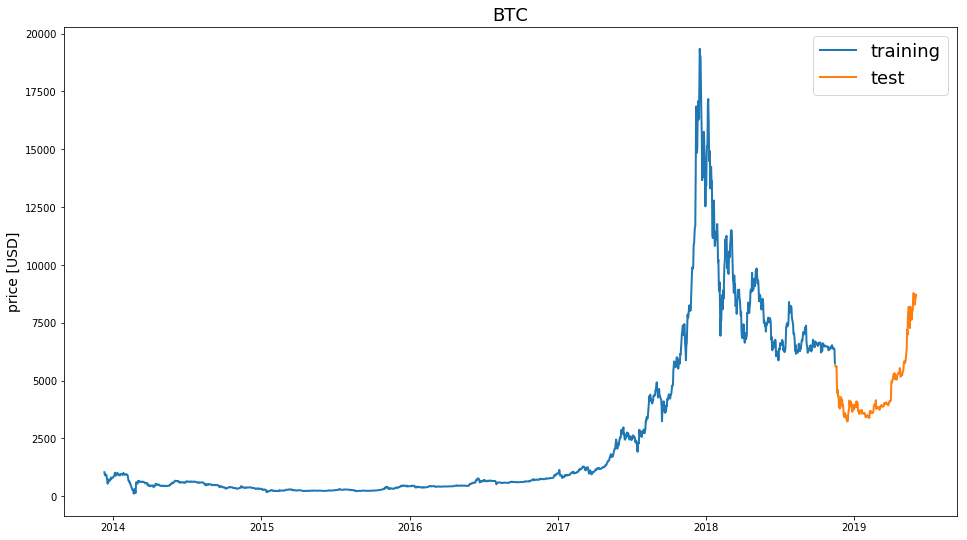

In [36]:
def train_test_split(df, test_size=0.1):
    split_row = len(df) - int(test_size * len(df))
    train_data = df.iloc[:split_row]
    test_data = df.iloc[split_row:]
    return train_data, test_data

def line_plot(line1, line2, label1=None, label2=None, title=''):
    fig, ax = plt.subplots(1, figsize=(16, 9))
    ax.plot(line1, label=label1, linewidth=2)
    ax.plot(line2, label=label2, linewidth=2)
    ax.set_ylabel('price [USD]', fontsize=14)
    ax.set_title(title, fontsize=18)
    ax.legend(loc='best', fontsize=18)
    
train, test = train_test_split(hist, test_size=0.1)
line_plot(train.close, test.close, 'training', 'test', 'BTC')

In [37]:
def normalise_zero_base(df):
    """ Normalise dataframe column-wise to reflect changes with
        respect to first entry.
    """
    return df / df.iloc[0] - 1

def extract_window_data(df, window=7, zero_base=True):
    """ Convert dataframe to overlapping sequences/windows of
        length `window`.
    """
    window_data = []
    for idx in range(len(df) - window):
        tmp = df[idx: (idx + window)].copy()
        if zero_base:
            tmp = normalise_zero_base(tmp)
        window_data.append(tmp.values)
    return np.array(window_data)

def prepare_data(df, window=7, zero_base=True, test_size=0.1):
    """ Prepare data for LSTM. """
    # train test split
    train_data, test_data = train_test_split(df, test_size)
    
    # extract window data
    X_train = extract_window_data(train_data, window, zero_base)
    X_test = extract_window_data(test_data, window, zero_base)
    
    # extract targets
    y_train = train_data.close[window:].values
    y_test = test_data.close[window:].values
    if zero_base:
        y_train = y_train / train_data.close[:-window].values - 1
        y_test = y_test / test_data.close[:-window].values - 1
    return train_data, test_data, X_train, X_test, y_train, y_test

train, test, X_train, X_test, y_train, y_test = prepare_data(hist)

In [38]:
print(X_train.shape)
print(X_train.shape)
print(y_test.shape)
print(y_test.shape)

(1794, 7, 6)
(1794, 7, 6)
(193,)
(193,)


In [42]:
TIME_STEPS = 7
BATCH_SIZE_OUT = 4 # 16 was better
LR = 0.005
# epochs = 150
EPOCHS = 50

In [122]:
def create_generator():
#     generator=Sequential()
#     generator.add(Dense(units=128,input_dim=8))
#     generator.add(LeakyReLU(0.2))
    
#     generator.add(Dense(units=256))
#     generator.add(LeakyReLU(0.2))
    
#     generator.add(Dense(units=512))
#     generator.add(LeakyReLU(0.2))
    
#     generator.add(Dense(units=8, activation='tanh'))
    
#     #generator.compile(loss='binary_crossentropy', optimizer=adam_optimizer(), metrics=['accuracy'])
#     generator.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

    # 6 below = x_t.shape[2]
#     generator = Sequential()
#     #generator.add(LSTM(16, batch_input_shape=(BATCH_SIZE_OUT, TIME_STEPS, 6), dropout=0.0, recurrent_dropout=0.0, stateful=True, kernel_initializer='random_uniform', return_sequences=False)) 
#     # stateful = true breaks the model (https://github.com/keras-team/keras/issues/9385)
#     generator.add(LSTM(16, batch_input_shape=(BATCH_SIZE_OUT, TIME_STEPS, 1), return_sequences=True)) 
#     generator.add(Dense(8,activation='relu'))
#     generator.add(Dropout(0.7))
#     generator.add(LSTM(8, return_sequences=False))
#     generator.add(Dense(1,activation='sigmoid'))
#     #generator.add(Reshape((TIME_STEPS, 1)))
#     optimizer = RMSprop(lr=LR, decay=3e-8)
#     #generator.compile(loss='mean_squared_error', optimizer='adam', metrics=['accuracy'])
#     generator.compile(loss='mean_squared_error', optimizer=optimizer, metrics=['accuracy'])
    
    
    generator = Sequential()
    generator.add(LSTM(16, batch_input_shape=(BATCH_SIZE_OUT, TIME_STEPS, 6), return_sequences=False))
    generator.add(LeakyReLU(0.5))
    generator.add(Dropout(0.5))
    generator.add(Dense(6))
    generator.add(Activation('tanh'))
    optimizer = RMSprop(lr=0.005, clipvalue=1.)
    generator.compile(loss='mean_squared_error', optimizer=optimizer)

    return generator
g=create_generator()
g.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_36 (LSTM)               (4, 16)                   1472      
_________________________________________________________________
leaky_re_lu_116 (LeakyReLU)  (4, 16)                   0         
_________________________________________________________________
dropout_116 (Dropout)        (4, 16)                   0         
_________________________________________________________________
dense_155 (Dense)            (4, 6)                    102       
_________________________________________________________________
activation_36 (Activation)   (4, 6)                    0         
Total params: 1,574
Trainable params: 1,574
Non-trainable params: 0
_________________________________________________________________


In [136]:
def create_discriminator():
    optimizer = RMSprop(lr=0.0002, decay=6e-8)

    discriminator=Sequential()
    #discriminator.add(Dense(units=512, batch_input_shape=(BATCH_SIZE_OUT, TIME_STEPS, 1)))
    discriminator.add(Dense(units=16, batch_input_shape=(8, TIME_STEPS, 6)))
    
    #discriminator.add(Dense(units=512,input_dim=6))
    discriminator.add(LeakyReLU(0.5))
    discriminator.add(Dropout(0.5))
       
    
#     discriminator.add(Dense(units=256))
#     discriminator.add(LeakyReLU(0.2))
#     discriminator.add(Dropout(0.3))
       
    discriminator.add(Dense(units=8))
    discriminator.add(LeakyReLU(0.5))
    discriminator.add(Dropout(0.5))
    
    #discriminator.add(Reshape((5, 1)))
    
    discriminator.add(Dense(units=6, activation='sigmoid'))
    
    discriminator.compile(loss='binary_crossentropy', optimizer=optimizer)

#     discriminator = Sequential()
#     discriminator.add(LSTM(16, batch_input_shape=(BATCH_SIZE_OUT, TIME_STEPS, 6), dropout=0.0, recurrent_dropout=0.0, kernel_initializer='random_uniform', return_sequences=False)) 
#     discriminator.add(Dense(8,activation='relu'))
#     discriminator.add(Dropout(0.7))
#     discriminator.add(Dense(1,activation='sigmoid'))

#     discriminator.compile(loss='mean_squared_error', optimizer='adam', metrics=['accuracy'])
    
    return discriminator
d =create_discriminator()
d.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_177 (Dense)            (8, 7, 16)                112       
_________________________________________________________________
leaky_re_lu_132 (LeakyReLU)  (8, 7, 16)                0         
_________________________________________________________________
dropout_132 (Dropout)        (8, 7, 16)                0         
_________________________________________________________________
dense_178 (Dense)            (8, 7, 8)                 136       
_________________________________________________________________
leaky_re_lu_133 (LeakyReLU)  (8, 7, 8)                 0         
_________________________________________________________________
dropout_133 (Dropout)        (8, 7, 8)                 0         
_________________________________________________________________
dense_179 (Dense)            (8, 7, 6)                 54        
Total para

In [137]:
def create_gan(discriminator, generator):
    optimizer = RMSprop(lr=0.0001, decay=3e-8)
    discriminator.trainable=False
    gan_input = Input(shape=(TIME_STEPS, 6)) # x_t.shape[2] = 6
    #Input(shape=(None, latent_dim))
    x = generator(gan_input)
    gan_output= discriminator(x)
    gan = Model(inputs=gan_input, outputs=gan_output)
    gan.compile(loss='binary_crossentropy', optimizer=optimizer)
    return gan
gan = create_gan(d,g)
gan.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_48 (InputLayer)        (None, 7, 6)              0         
_________________________________________________________________
sequential_76 (Sequential)   multiple                  1574      
_________________________________________________________________
sequential_86 (Sequential)   multiple                  302       
Total params: 1,876
Trainable params: 1,574
Non-trainable params: 302
_________________________________________________________________


In [140]:
import keras.backend as K

adversarial_loss = []
discrimator_loss = []
gen_samples = []

#K.clear_session()
generator = create_generator()
discriminator = create_discriminator()
gan = create_gan(discriminator, generator)
#(X_train, y_train, X_val, X_test, y_val, y_test) = load_data(x_train_out, x_test_out, BATCH_SIZE_OUT)

def training(epochs=1, batch_size=128):
    global adversarial_loss
    global discrimator_loss
    global gen_samples
    
    global generator
    global discriminator
    global gan

    global X_train
    global X_test
    global y_train
    global y_test
    
    for e in range(1, epochs+1 ):
        print("Epoch %d" %e)
        for i in tqdm(range(batch_size)):
            #generate  random noise as an input  to  initialize the  generator
            #noise = np.random.normal(0,1, [BATCH_SIZE_OUT, TIME_STEPS, X_train.shape[2]])
            print(X_train.shape)
            
            noise = np.float32(np.random.normal(size=[BATCH_SIZE_OUT, TIME_STEPS, X_train.shape[2]]))
            
            # Generate fake prices from noised input
            generated_prices = generator.predict(noise)
            
            # Get a random set of real prices
            prices_batch = X_train[np.random.randint(low=0,high=X_train.shape[0],size=BATCH_SIZE_OUT)]
            
            
            dim_0 = generated_prices.shape[0] - TIME_STEPS
            dim_0 = generated_prices.shape[0]
            gen_prices = np.zeros((dim_0, TIME_STEPS, 6))
            
            for j in range(dim_0):
                gen_prices[j] = generated_prices[j]

#             print('Shapes 1')
#             print(noise.shape)
#             print(prices_batch.shape)
#             print(generated_prices.shape)     
#             print(gen_prices.shape)
#             print('>>>>>>>>>>>gen_prices>>>>>>>')            
#             print(gen_prices)
#             #print(prices_batch)
#             #print(generated_prices)
            
            #Construct different batches of real and fake data 
            X = np.concatenate([prices_batch, gen_prices])
            
            # Labels for generated and real data
            #y_dis = np.zeros(2*batch_size)
            #y_dis = np.zeros(shape=(2*BATCH_SIZE_OUT, TIME_STEPS, X_train.shape[2]))
            y_dis = np.zeros(shape=(X.shape[0], TIME_STEPS, X_train.shape[2]))
            #y_dis[:batch_size]=0.9
            y_dis[:int((X.shape[0]/2))]=0.9
            #y_dis[0,:,batch_size]=0.9
            
#             print('Shapes 2')
#             print(X.shape)
#             print(y_dis.shape)
#             print('>>>>>>>>>>>x>>>>>>>')
#             print(X)
#             print('>>>>>>>>>>>y_dis>>>>>>>')            
#             print(y_dis)
            
            #Pre train discriminator on fake and real data before starting the gan. 
            discriminator.trainable = True
            d_loss = discriminator.train_on_batch(X, y_dis)
            
            #Tricking the noised input of the Generator as real data
            #noise = np.random.normal(0,1, [batch_size, 8])
            #y_gen = np.ones(batch_size)
            noise = np.float32(np.random.normal(size=[BATCH_SIZE_OUT, TIME_STEPS, X_train.shape[2]]))
            #y_gen = np.ones(shape=(noise.shape[0], TIME_STEPS, X_train.shape[2]))
            y_gen = np.ones(BATCH_SIZE_OUT)
            
            # During the training of gan, 
            # the weights of discriminator should be fixed. 
            #We can enforce that by setting the trainable flag
            discriminator.trainable=False
            
#             print('Shapes 3')
#             print(noise.shape)
#             print(y_gen.shape)
            
            #training the GAN by alternating the training of the Discriminator 
            #and training the chained GAN model with Discriminator’s weights freezed.
            a_loss = gan.train_on_batch(noise, y_gen)
            
            if i == (batch_size-1):
                #log_mesg = "%d: [D loss: %f, acc: %f]" % (e, d_loss[0], d_loss[1])
                #log_mesg = "%s  [A loss: %f, acc: %f]" % (log_mesg, a_loss[0], a_loss[1])
                log_mesg = "%d: [D loss: %f]" % (e, d_loss)
                log_mesg = "%s  [A loss: %f]" % (log_mesg, a_loss)
                print(log_mesg)
                
            discrimator_loss.append(d_loss)
            adversarial_loss.append(a_loss)
            
#         if e == 1 or e % 5 == 0:
#             # generate synthetic dataset
#             gen_samples_set = []
#             for batch_idx in range(int(len(X_train) / batch_size)):
#             # for batch_idx in range(int(len(X_train) / 100)):
#                 # noise= np.random.normal(loc=0, scale=1, size=[100, 100])
#                 #noise= np.random.normal(0,1, [batch_size, 8])
#                 noise = np.float32(np.random.normal(size=[BATCH_SIZE_OUT, TIME_STEPS, X_train.shape[2]]))
#                 generated_data = generator.predict(noise)
#                 gen_samples_set.append(generated_data)

#             gen_samples = np.vstack(gen_samples_set)

In [141]:
#training(400,128)
training(1,12)

  0%|          | 0/12 [00:00<?, ?it/s]

Epoch 1
(1794, 7, 6)
Shapes 3
(4, 7, 6)
(4,)


ValueError: Error when checking target: expected sequential_90 to have shape (6,) but got array with shape (1,)

In [16]:
# generated_data = np.transpose(gen_samples)
# #print(gen_samples)
# #print(generated_data)
# #plot the log-returns
# gen_ind = 1 # change in function price as well
# pd.DataFrame(gen_samples).plot()

In [17]:
def get_2D_array_values(arr, idx):
    arr_map = []
    for i in range(len(arr)):
        arr_map.append(arr[i][idx])
    
    return arr_map

Text(0,0.5,'Loss')

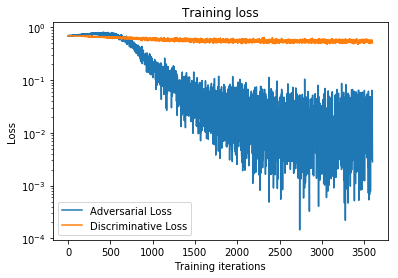

In [18]:
# adversarial_loss_map = get_2D_array_values(adversarial_loss, 0)
# discrimator_loss_map = get_2D_array_values(discrimator_loss, 0)

ax = pd.DataFrame(
    {
        'Adversarial Loss': adversarial_loss,
        'Discriminative Loss': discrimator_loss,
    }
).plot(title='Training loss', logy=True)
ax.set_xlabel("Training iterations")
ax.set_ylabel("Loss")

In [19]:
# adversarial_acc_map = get_2D_array_values(adversarial_loss, 1)
# discrimator_acc_map = get_2D_array_values(discrimator_loss, 1)

# ax_acc = pd.DataFrame(
#     {
#         'Adversarial Accuracy': adversarial_acc_map,
#         'Discriminative Accuracy': discrimator_acc_map,
#     }
# ).plot(title='Training loss', logy=True)
# ax_acc.set_xlabel("Training iterations")
# ax_acc.set_ylabel("Accuracy")

In [25]:
#(X_train2, X_test2, y_train2, y_test2) = load_data_with_test2()
#(X_train2, y_train2, X_val2, X_test2, y_val2, y_test2) = load_data(x_train_out, x_test_out, BATCH_SIZE_OUT)

# print(x_train_out.shape)
# print(x_test_out.shape)

# print(X_train.shape)
# print(X_test.shape)
# print(X_val.shape)

prediction_gan = gan.predict(X_test)

# print("The Explained Variance: %.2f" % prediction_gan.score(X_test2, y_test2))  
print("The Explained Variance: %.2f" % metrics.explained_variance_score(y_test, prediction_gan))  
print("The Mean Absolute Error: %.2f" % metrics.mean_absolute_error(y_test, prediction_gan))  
#print("The Median Absolute Error: %.2f" % metrics.median_absolute_error(y_test2, prediction_gan)) 
print("The Mean Squared Error: %.2f" % metrics.mean_squared_error(y_test, prediction_gan)) 
print("The Root Mean Squared Error: %.2f" % (np.sqrt(metrics.mean_squared_error(y_test, prediction_gan))))

#generator.predict(X_train)[0]

The Explained Variance: -0.00
The Mean Absolute Error: 1.00
The Mean Squared Error: 1.01
The Root Mean Squared Error: 1.00


In [29]:
y_pred = gan.predict(trim_dataset(X_test, BATCH_SIZE_OUT), batch_size=BATCH_SIZE_OUT)
y_pred = y_pred.flatten()
y_test_t = trim_dataset(y_test, BATCH_SIZE_OUT)
error = metrics.mean_squared_error(y_test_t, y_pred)
print("Error is", error, y_pred.shape, y_test_t.shape)
print(y_pred[0:15])
print(y_test_t[0:15])

Error is 1.0084690175330027 (3180,) (3180,)
[0.9999161 0.9999161 0.9999161 0.9999161 0.9999161 0.9999161 0.9999161
 0.9999161 0.9999161 0.9999161 0.9999161 0.9999161 0.9999161 0.9999161
 0.9999161]
[-0.00187447 -0.00195998 -0.00187498 -0.00187498 -0.00187498 -0.00198007
 -0.00206197 -0.00204497 -0.00189765 -0.00192649 -0.00187498 -0.00191877
 -0.00187395 -0.0019677  -0.00193113]


In [30]:
# convert the predicted value to range of real data
y_pred_org = (y_pred * min_max_scaler.data_range_[0]) + min_max_scaler.data_min_[0]
#y_pred_org = (y_pred + min_max_scaler.data_min_[0])
# min_max_scaler.inverse_transform(y_pred)
y_test_t_org = (y_test_t * min_max_scaler.data_range_[0]) + min_max_scaler.data_min_[0]
#y_test_t_org = (y_test_t + min_max_scaler.data_min_[0])
# min_max_scaler.inverse_transform(y_test_t)
print(y_pred_org[0:15])
print(y_test_t_org[0:15])

[19868.23 19868.23 19868.23 19868.23 19868.23 19868.23 19868.23 19868.23
 19868.23 19868.23 19868.23 19868.23 19868.23 19868.23 19868.23]
[419.97 418.31 419.96 419.96 419.96 417.92 416.33 416.66 419.52 418.96
 419.96 419.11 419.98 418.16 418.87]


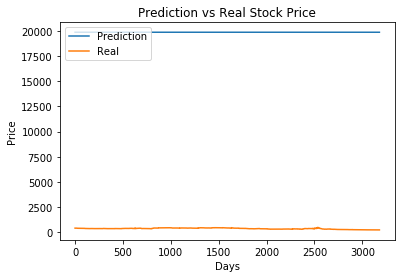

In [31]:
# Visualize the prediction
from matplotlib import pyplot as plt
plt.figure()
plt.plot(y_pred_org)
plt.plot(y_test_t_org)
plt.title('Prediction vs Real Stock Price')
plt.ylabel('Price')
plt.xlabel('Days')
plt.legend(['Prediction', 'Real'], loc='upper left')
plt.show()
